Lindsay Spoor, s1983822
Master Research Project 2023-2024
MARL for QEC


# Toric Code Game

This notebook provides an overview of training and evaluating an RL agent (PPO using stable-baselines3) on a toric code environment. 

First, the agent will be trained with the specified parameter settings. Afterwards, the trained agent can be evaluated and benchmarked against the performance of a MWPM decoding algorithm. 


The setup of the game in this notebook is as follows:

1. The environment introduces N initial (bit-flip only) errors on qubits on the dxd board
2. Agent sees the board state: the outcome of syndrome measurements on the board
3. Agent decodes by doing bit-flips (as many as it wants) on qubits on the board until all syndrome points are resolved
4. Board is checked on logical errors and agent is rewarded according to the state of the game
5. Repeat this process durign training and evaluating

The agent is evaluated by calculating the success rate $p_s$, that is, the number of successes divided the total number of played games on the board. These results are benchmarked against the MWPM success rate.


# Toric Code Environment

The toric code environment is a dxd board with on each vertex of the grid a qubit, in total 2dxd qubits, and dxd plaquette and star operators. The eigenvalues of the plaquettes and stars indicate syndromes when having an eigenvalue of -1, and not having a syndrome when having an eigenvalue of 1. The environment used for this setup is from this paper:

https://arxiv.org/abs/2101.08093

# Reward system

After each action the agent takes it gets a reward: -1 for each step not resulting in an end state (= no syndromes left on the board), +10 for reaching an end state and not having any logical errors present on the board, +5 for reaching an end state but having a logical error on the board. 

A logical error is defined as a non-trivial loop of error strings on the board. The toric code is a surface code with periodic boundaries. Therefore, when error strings are connecting one side of a boundary to the other, this results in a non-trivial loop which causes a logical error on the board. The goal of the agent is therefore not only removing all syndrome points on the board, but also developing a clever strategy on how to prevent the board from having a logical error. 



In [21]:
# code from (and adjusted to this use-case) https://github.com/condensedAI/neat-qec/blob/main/toric_game_env.py
from __future__ import division
from typing import Any
import numpy as np

import gymnasium as gym
#import gym
from gymnasium.utils import seeding
from gymnasium import spaces
import matplotlib.pyplot as plt



### Environment
class ToricGameEnv(gym.Env):
    '''
    ToricGameEnv environment. Effective single player game.
    '''

    def __init__(self, settings):
        """
        Args:
            opponent: Fixed
            board_size: board_size of the board to use
        """

        self.settings=settings

        self.board_size = settings['board_size']
        self.channels = [0]
        self.memory = False
        self.error_rate = settings['error_rate']
        self.logical_error_reward=settings['l_reward']
        self.continue_reward=settings['c_reward']
        self.success_reward=settings['s_reward']
        self.mask_actions=settings['mask_actions']
        self.N = settings['N']

        # Keep track of the moves
        self.qubits_flips = [[],[]]
        self.initial_qubits_flips = [[],[]]


        # Empty State
        self.state = Board(self.board_size)
        self.done = None

        self.observation_space = spaces.MultiBinary(self.board_size*self.board_size) #dxd plaquettes on which we can view syndromes
        self.action_space = spaces.discrete.Discrete(len(self.state.qubit_pos)) #0-2dxd qubits on which a bit-flip error can be introduced


    def seed(self, seed=None):
        self.np_random, seed1 = seeding.np_random(seed)
        # Derive a random seed.
        seed2 = seeding.hash_seed(seed1 + 1) % 2**32
        return [seed1, seed2]

    def action_masks(self):

        self.action_masks_list=np.zeros((len(self.state.qubit_pos)))
        self.action_masks_list[:]=False
        for i in self.state.syndrome_pos:
            a,b = i[0],i[1]
            mask_coords = [[(a-1)%(2*self.state.size),b%(2*self.state.size)],[a%(2*self.state.size),(b-1)%(2*self.state.size)],[a%(2*self.state.size),(b+1)%(2*self.state.size)],[(a+1)%(2*self.state.size),b%(2*self.state.size)]]
            for j in mask_coords:
                qubit_number = self.state.qubit_pos.index(j)

                self.action_masks_list[qubit_number]=True



        self.action_masks_list=list(self.action_masks_list)

        return self.action_masks_list





    def generate_errors(self):
        # Reset the board state

        self.state.reset()

        # Let the opponent do it's initial evil
        self.qubits_flips = [[],[]]
        self.initial_qubits_flips = [[],[]]

        self._set_initial_errors()

        self.done = self.state.is_terminal()

        self.reward = 0
        if self.done:
            self.reward = self.success_reward
            if self.state.has_logical_error(self.initial_qubits_flips):
                self.reward = self.logical_error_reward


        return self.state.encode(self.channels, self.memory)

    def reset(self, *, seed: int | None = None, options: dict[str, Any] | None = None) -> tuple[Any, dict[str, Any]]:
         super().reset(seed=seed, options=options)

         initial_observation = self.generate_errors()

         return initial_observation, {'state': self.state, 'message':"reset"}


    def close(self):
        self.state = None

    def render(self, mode="human", close=False):
        fig, ax = plt.subplots()
        a=1/(2*self.board_size)

        for i, p in enumerate(self.state.plaquet_pos):
            if self.state.op_values[0][i]==1:
                fc='darkorange'
                plaq = plt.Polygon([[a*p[0], a*(p[1]-1)], [a*(p[0]+1), a*(p[1])], [a*p[0], a*(p[1]+1)], [a*(p[0]-1), a*p[1]] ], fc=fc)
                ax.add_patch(plaq)

        for i, p in enumerate(self.state.star_pos):
            if self.state.op_values[1][i]==1:
                fc = 'green'
                plaq = plt.Polygon([[a*p[0], a*(p[1]-1)], [a*(p[0]+1), a*(p[1])], [a*p[0], a*(p[1]+1)], [a*(p[0]-1), a*p[1]] ], fc=fc)
                ax.add_patch(plaq)

        # Draw lattice
        for x in range(self.board_size):
            for y in range(self.board_size):
                pos=(2*a*x, 2*a*y)
                width=a*2
                lattice = plt.Rectangle( pos, width, width, fc='none', ec='black' )
                ax.add_patch(lattice)

        for i, p in enumerate(self.state.qubit_pos):
            pos=(a*p[0], a*p[1])
            fc='darkgrey'
            if self.state.qubit_values[0][i] == 1 and self.state.qubit_values[1][i] == 0:
                fc='darkblue'
            elif self.state.qubit_values[0][i] == 0 and self.state.qubit_values[1][i] == 1:
                fc='darkred'
            elif self.state.qubit_values[0][i] == 1 and self.state.qubit_values[1][i] == 1:
                fc='darkmagenta'
            circle = plt.Circle( pos , radius=a*0.25, ec='k', fc=fc)
            ax.add_patch(circle)
            plt.annotate(str(i), pos, fontsize=8, ha="center")

        ax.set_xlim([-.1,1.1])
        ax.set_ylim([-.1,1.1])
        ax.set_aspect(1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.axis('off')
        plt.show()

    def step(self, location,  without_illegal_actions=True):

        '''
        Args:
            location: coord of the qubit to flip
            operator: Pauli matrix to apply
        Return:
            observation: board encoding,
            reward: reward of the game,
            done: boolean,
            info: state dict
        '''



        if self.done:
            self.reward = self.success_reward
            return self.state.encode(self.channels, self.memory), self.success_reward, True, False,{'state': self.state, 'message':"success"}

 
        pauli_opt=0
        pauli_X_flip=True
        pauli_Z_flip=False


        # Check if we flipped twice the same qubit

        if not without_illegal_actions:
            if pauli_X_flip and location in self.qubits_flips[0]:
                return self.state.encode(self.channels, self.memory), -1000, True, False,{'state': self.state, 'message': "illegal_action"}
            if pauli_Z_flip and location in self.qubits_flips[1]:
                return self.state.encode(self.channels, self.memory), -1000, True, False,{'state': self.state, 'message': "illegal_action"}
        


        if pauli_X_flip:
            self.qubits_flips[0].append(location)

        if pauli_Z_flip:
            self.qubits_flips[1].append(location)


        
        self.state.act(self.state.qubit_pos[location], pauli_opt)

        # agent gets reward if it does an action but it does not result in a terminal board state
        if not self.state.is_terminal():
            self.done = False

            return self.state.encode(self.channels, self.memory), self.continue_reward, False, False,{'state': self.state, 'message':"continue"}
    

        # We're in a terminal state. Reward depends on whether it has won or lost (=logical error)
        self.done = True
        if self.state.has_logical_error(self.initial_qubits_flips):
            return self.state.encode(self.channels, self.memory), self.logical_error_reward, True, False,{'state': self.state, 'message':"logical_error"}
        else:
            return self.state.encode(self.channels, self.memory), self.success_reward, True, False,{'state': self.state, 'message':"success"}




    def _set_initial_errors(self):
        ''' Set random initial errors with an %error_rate rate
            but report only the syndrome
        '''
        # Probabilitic mode
        # Pick random sites according to error rate

        for q in self.state.qubit_pos:    
            if np.random.rand() < self.error_rate:
                #print(f" qubit has bit flip error on {self.state.qubit_pos.index(q)}")

                pauli_opt = 0


                pauli_X_flip = (pauli_opt==0 or pauli_opt==2)
                pauli_Z_flip = (pauli_opt==1 or pauli_opt==2)


                if pauli_X_flip:
                    self.initial_qubits_flips[0].append( q )
                if pauli_Z_flip:
                    self.initial_qubits_flips[1].append( q )

                self.state.act(q, pauli_opt)


        # Now unflip the qubits, they're a secret
        self.state.qubit_values = np.zeros((2, 2*self.board_size*self.board_size))






class ToricGameEnvFixedErrs(ToricGameEnv):
    '''This environment is designed to initialise a board with N initial bit-flip errors instead of 
    introducing errors on the board according to an error rate.'''
    
    def __init__(self, settings):
        super().__init__(settings)
        

    def _set_initial_errors(self):
        ''' Set random initial errors for N initial flips
            but report only the syndrome
        '''
        # Probabilistic mode
        for q in np.random.choice(len(self.state.qubit_pos), self.N, replace=False): 

            q = self.state.qubit_pos[q]

            pauli_opt = 0

            pauli_X_flip = (pauli_opt==0 or pauli_opt==2)
            pauli_Z_flip = (pauli_opt==1 or pauli_opt==2)


            if pauli_X_flip:
                self.initial_qubits_flips[0].append( q )
            if pauli_Z_flip:
                self.initial_qubits_flips[1].append( q )


            self.state.act(q, pauli_opt)

        # Now unflip the qubits, they're a secret
        self.state.qubit_values = np.zeros((2, 2*self.board_size*self.board_size))





class Board(object):
    '''
    Basic Implementation of a ToricGame Board, actions are int [0,2*board_size**2)
    o : qubit
    P : plaquette operator
    x : star operator

    x--o---x---o---x---o---
    |      |       |
    o  P   o   P   o   P
    |      |       |
    x--o---x---o---x---o---
    |      |       |
    o  P   o   P   o   P
    |      |       |
    x--o---x---o---x---o---
    |      |       |
    o  P   o   P   o   P
    |      |       |

    '''
    @staticmethod
    def component_positions(size):
        qubit_pos   = [[x,y] for x in range(2*size) for y in range((x+1)%2, 2*size, 2)]
        plaquet_pos = [[x,y] for x in range(1,2*size,2) for y in range(1,2*size,2)]
        star_pos    = [[x,y] for x in range(0,2*size,2) for y in range(0,2*size,2)]

        return qubit_pos, plaquet_pos, star_pos

    def __init__(self, board_size):
        self.size = board_size

        # Real-space locations
        self.qubit_pos, self.plaquet_pos, self.star_pos  = self.component_positions(self.size)

        # Mapping between 1-index and 2D position
        '''
        self.qubit_dict, self.star_dict, self.plaquet_dict = {},{},{}
        for i in range(2*self.size*self.size):
            self.qubit_dict[self.qubit_pos[i]] = i
        for i in range(self.size*self.size):
            self.star_dict[i] = self.star_pos[i]
            self.plaquet_dict[i] = self.plaquet_pos[i]
        '''

        # Define here the logical error for efficiency
        self.z1pos = [[0,x] for x in range(1, 2*self.size, 2)]
        self.z2pos = [[y,0] for y in range(1, 2*self.size, 2)]
        self.x1pos = [[1,x] for x in range(0, 2*self.size, 2)]
        self.x2pos = [[y,1] for y in range(0, 2*self.size, 2)]

        self.reset()

    def reset(self):
        #self.board_state = np.zeros( (2, 2*self.size, 2*self.size) )
        
        self.qubit_values = np.zeros((2, 2*self.size*self.size))
        self.op_values = np.zeros((2, self.size*self.size))

        self.syndrome_pos = [] # Location of syndromes

    def act(self, coord, operator):
        '''
            Args: input action in the form of position [x,y]
            coord: real-space location of the qubit to flip
        '''

        pauli_X_flip = (operator==0 or operator==2)
        pauli_Z_flip = (operator==1 or operator==2)




        qubit_index=self.qubit_pos.index(coord)


        # Flip it!
        if pauli_X_flip:
            self.qubit_values[0][qubit_index] = (self.qubit_values[0][qubit_index] + 1) % 2
        if pauli_Z_flip:
            self.qubit_values[1][qubit_index] = (self.qubit_values[1][qubit_index] + 1) % 2



        # Update the syndrome measurements
        # Only need to incrementally change
        # Find plaquettes that the flipped qubit is a part of
        plaqs=[]
        if pauli_X_flip:
            if coord[0] % 2 == 0:
                plaqs += [ [ (coord[0] + 1) % (2*self.size), coord[1] ], [ (coord[0] - 1) % (2*self.size), coord[1] ] ]
            else:
                plaqs += [ [ coord[0], (coord[1] + 1) % (2*self.size) ], [ coord[0], (coord[1] - 1) % (2*self.size) ] ]

        if pauli_Z_flip:
            if coord[0] % 2 == 0:
                plaqs += [ [ coord[0], (coord[1] + 1) % (2*self.size) ], [ coord[0], (coord[1] - 1) % (2*self.size) ] ]
            else:
                plaqs += [ [ (coord[0] + 1) % (2*self.size), coord[1] ], [ (coord[0] - 1) % (2*self.size), coord[1] ] ]


        # Update syndrome positions
        for plaq in plaqs:
            if plaq in self.syndrome_pos:
                self.syndrome_pos.remove(plaq)
            else:
                self.syndrome_pos.append(plaq)

            # The plaquette or vertex operators are only 0 or 1
            if plaq in self.star_pos:
                op_index = self.star_pos.index(plaq)
                channel = 1
            elif plaq in self.plaquet_pos:
                op_index = self.plaquet_pos.index(plaq)
                channel = 0

        
            self.op_values[channel][op_index] = (self.op_values[channel][op_index] + 1) % 2





    def is_terminal(self):
        # Not needed I think
        #if len(self.get_legal_action()) == 0:
        #    return True

        # Are all syndromes removed?
        return len(self.syndrome_pos) == 0

    def has_logical_error(self, initialmoves, debug=False):
        if debug:
            print("Initial errors:", [self.qubit_pos.index(q) for q in initialmoves])



        # Check for Z logical error
        zerrors = [0,0]
        for pos in self.z1pos:
            if pos in initialmoves[0]:
                zerrors[0] += 1
            qubit_index = self.qubit_pos.index(pos)
            zerrors[0] += self.qubit_values[0][ qubit_index ]

        for pos in self.z2pos:
            if pos in initialmoves[0]:
                zerrors[1] += 1
            qubit_index = self.qubit_pos.index(pos)
            zerrors[1] += self.qubit_values[0][ qubit_index ]

        # Check for X logical error
        xerrors = [0,0]
        for pos in self.x1pos:
            if pos in initialmoves[1]:
                xerrors[0] += 1
            qubit_index = self.qubit_pos.index(pos)
            xerrors[0] += self.qubit_values[1][ qubit_index ]

        for pos in self.x2pos:
            if pos in initialmoves[1]:
                xerrors[1] += 1
            qubit_index = self.qubit_pos.index(pos)
            xerrors[1] += self.qubit_values[1][ qubit_index ]



        if (zerrors[0]%2 == 1) or (zerrors[1]%2 == 1) or \
            (xerrors[0]%2 == 1) or (xerrors[1]%2 == 1):
            return True

        return False


    def __repr__(self):
        ''' representation of the board class
            print out board_state
        '''
        return f"Qubit Values: {self.qubit_values}, Operator values: {self.op_values}"

    def encode(self, channels, memory):
        '''Return: np array
            np.array(board_size, board_size): state observation of the board
        '''
        # In case of uncorrelated noise for instance, we don't need information
        # about the star operators

        img=np.array([])
        for channel in channels:
            img = np.concatenate((img, self.op_values[channel]))
            if memory:
                img = np.concatenate((img, self.qubit_values[channel]))

        return img

    def image_view(self, number=False, channel=0):
        image = np.empty((2*self.size, 2*self.size), dtype=object)

        for i, plaq in enumerate(self.plaquet_pos):
            if self.op_values[0][i] == 1:
                image[plaq[0], plaq[1]] = "P"+str(i) if number else "P"
            elif self.op_values[0][i] == 0:
                image[plaq[0], plaq[1]] = "x"+str(i) if number else "x"
        for i,plaq in enumerate(self.star_pos):
            if self.op_values[1][i] == 1:
                image[plaq[0], plaq[1]] = "S"+str(i) if number else "S"
            elif self.op_values[1][i] == 0:
                image[plaq[0], plaq[1]] = "+"+str(i) if number else "+"

        for i,pos in enumerate(self.qubit_pos):
            image[pos[0], pos[1]] = str(int(self.qubit_values[channel,i]))+str(i) if number else str(int(self.qubit_values[channel, i]))

        return np.array(image)


# PPO Agent

Using stable-baselines3 the agent is a PPO agent. The agent uses an action mask to mask out all actions that are not 'allowed', that is, the agent is only allowed to select actions (qubits) adjacent to syndrome points, in order to make convergence during training happening faster.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from stable_baselines3.ppo.policies import MlpPolicy
import os
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.utils import get_action_masks
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.policies import obs_as_tensor
import networkx as nx
from tqdm import tqdm
os.getcwd()



#logger
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, f"best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

class PPO_agent:
    def __init__(self, initialisation_settings, log):#path):

        self.initialisation_settings=initialisation_settings
        # Create log dir
        self.log=log
        if self.log:
            self.log_dir = "log_dir"
            os.makedirs(self.log_dir, exist_ok=True)



        #INITIALISE MODEL FOR INITIALISATION
        self.initialise_model()

    def initialise_model(self):
        #INITIALISE ENVIRONMENT INITIALISATION
        print("initialising the environment and model...")
        if self.initialisation_settings['fixed']:
            self.env = ToricGameEnvFixedErrs(self.initialisation_settings)
        else:
            self.env = ToricGameEnv(self.initialisation_settings)


        # Logs will be saved in log_dir/monitor.csv
        if self.log:
            self.env = Monitor(self.env, self.log_dir)
            # Create the callback: check every ... steps
            self.callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=self.log_dir)
            
        #INITIALISE MODEL FOR INITIALISATION
        if self.initialisation_settings['mask_actions']:
            ppo = MaskablePPO
            policy = MaskableActorCriticPolicy
        else:
            ppo= PPO
            policy = MlpPolicy
        
        self.model = ppo(policy, self.env, ent_coef=self.initialisation_settings['ent_coef'], clip_range = self.initialisation_settings['clip_range'],learning_rate=self.initialisation_settings['lr'], verbose=0, policy_kwargs={"net_arch":dict(pi=[64,64], vf=[64,64])})

        print("initialisation done")
        print(self.model.policy)

    def change_environment_settings(self, settings):
        print("changing environment settings...")
        if settings['fixed']:
            self.env = ToricGameEnvFixedErrs(settings)
        else:
            self.env = ToricGameEnv(settings)

        # Logs will be saved in log_dir/monitor.csv
        if self.log:
            self.env = Monitor(self.env, self.log_dir)
            # Create the callback: check every 1000 steps
            self.callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=self.log_dir)
        
        self.model.set_env(self.env)

        print("changing settings done")

    def train_model(self, save_model_path):
        print("training the model...")
        if self.log:
            self.model.learn(total_timesteps=self.initialisation_settings['total_timesteps'], progress_bar=True, callback=self.callback)
            self.plot_results(self.log_dir, save_model_path)
        else:
            self.model.learn(total_timesteps=self.initialisation_settings['total_timesteps'], progress_bar=True)
    
        self.model.save(f"model_ppo_{save_model_path}")
        print("training done")

    def load_model(self, load_model_path):
        print("loading the model...")
        if self.initialisation_settings['mask_actions']:
            self.model=MaskablePPO.load(f"model_ppo_{load_model_path}")
        else:
            self.model=PPO.load(f"model_ppo_{load_model_path}")
        print("loading done")
    
    def moving_average(self,values, window): #for plotting the learning curve
        """
        Smooth values by doing a moving average
        :param values: (numpy array)
        :param window: (int)
        :return: (numpy array)
        """
        weights = np.repeat(1.0, window) / window
        print(values)
        return np.convolve(values, weights, "valid")

    def plot_results(self,log_folder, save_model_path, title="Learning Curve"): #for plotting the learning curve
        """
        plot the results

        :param log_folder: (str) the save location of the results to plot
        :param title: (str) the title of the task to plot
        """
        x, y = ts2xy(load_results(log_folder), "timesteps")
        y = self.moving_average(y, window=50)
        # Truncate x
        x = x[len(x) - len(y) :]

        fig = plt.figure(title)
        plt.plot(x, y)
        plt.yscale("linear")
        plt.xlabel("Number of Timesteps")
        plt.ylabel("Rewards")
        plt.title(title + " Smoothed")
        plt.savefig(f'learning_curve_{save_model_path}.pdf')


    def render(self, obs0_k,evaluation_settings, actions_k, initial_flips_k): #for rendering the environment during evaluation (if needed)
        #renders both the MWPM strategy and the PPO agent strategy, as well as the initial bit flips introduced by the environment

        size=evaluation_settings['board_size']
        qubit_pos   = [[x,y] for x in range(2*size) for y in range((x+1)%2, 2*size, 2)]
        plaquet_pos = [[x,y] for x in range(1,2*size,2) for y in range(1,2*size,2)]


        fig, (ax3,ax1,ax2) = plt.subplots(1,3, figsize=(15,5))
        a=1/(2*size)

        for i, p in enumerate(plaquet_pos):
            if obs0_k.flatten()[i]==1:

                fc='darkorange'
                plaq = plt.Polygon([[a*p[0], a*(p[1]-1)], [a*(p[0]+1), a*(p[1])], [a*p[0], a*(p[1]+1)], [a*(p[0]-1), a*p[1]] ], fc=fc)
                ax1.add_patch(plaq)

        for i, p in enumerate(plaquet_pos):
            if obs0_k.flatten()[i]==1:

                fc='darkorange'
                plaq = plt.Polygon([[a*p[0], a*(p[1]-1)], [a*(p[0]+1), a*(p[1])], [a*p[0], a*(p[1]+1)], [a*(p[0]-1), a*p[1]] ], fc=fc)
                ax2.add_patch(plaq)

        for i, p in enumerate(plaquet_pos):
            if obs0_k.flatten()[i]==1:

                fc='darkorange'
                plaq = plt.Polygon([[a*p[0], a*(p[1]-1)], [a*(p[0]+1), a*(p[1])], [a*p[0], a*(p[1]+1)], [a*(p[0]-1), a*p[1]] ], fc=fc)
                ax3.add_patch(plaq)

        # Draw lattice
        for x in range(size):
            for y in range(size):
                pos=(2*a*x, 2*a*y)
                width=a*2
                lattice = plt.Rectangle( pos, width, width, fc='none', ec='black' )
                ax1.add_patch(lattice)

        for x in range(size):
            for y in range(size):
                pos=(2*a*x, 2*a*y)
                width=a*2
                lattice = plt.Rectangle( pos, width, width, fc='none', ec='black' )
                ax2.add_patch(lattice)

        for x in range(size):
            for y in range(size):
                pos=(2*a*x, 2*a*y)
                width=a*2
                lattice = plt.Rectangle( pos, width, width, fc='none', ec='black' )
                ax3.add_patch(lattice)

        for i, p in enumerate(qubit_pos):
            pos=(a*p[0], a*p[1])
            fc1='darkgrey'
            if i in list(actions_k[:,0]):
                fc1 = 'darkblue'


            circle1 = plt.Circle( pos , radius=a*0.25, ec='k', fc=fc1)
            ax1.add_patch(circle1)
            ax1.annotate(str(i), pos, fontsize=8, ha="center")
        
        for i, p in enumerate(qubit_pos):
            pos=(a*p[0], a*p[1])
            fc2='darkgrey'
            if i in list(actions_k[:,1]):
                fc2 = 'red'


            circle2 = plt.Circle( pos , radius=a*0.25, ec='k', fc=fc2)
            ax2.add_patch(circle2)
            ax2.annotate(str(i), pos, fontsize=8, ha="center")

        for i, p in enumerate(qubit_pos):
            pos=(a*p[0], a*p[1])
            fc3='darkgrey'
            if p in list(initial_flips_k)[0]:
                fc3 = 'magenta'


            circle3 = plt.Circle( pos , radius=a*0.25, ec='k', fc=fc3)
            ax3.add_patch(circle3)
            ax3.annotate(str(i), pos, fontsize=8, ha="center")

        ax1.set_xlim([-.1,1.1])
        ax1.set_ylim([-.1,1.1])
        ax1.set_aspect(1)
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_title("actions agent")
        ax2.set_xlim([-.1,1.1])
        ax2.set_ylim([-.1,1.1])
        ax2.set_aspect(1)
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.set_title("actions MWPM")
        ax1.axis('off')
        ax2.axis('off')
        ax3.set_xlim([-.1,1.1])
        ax3.set_ylim([-.1,1.1])
        ax3.set_aspect(1)
        ax3.set_xticks([])
        ax3.set_yticks([])
        ax3.set_title("initial qubit flips")
        ax3.axis('off')
        plt.show()



    ################ MWPM Decoding functions ##################################

    def matching_to_path(self,matchings, grid_q): #for MWPM decoding

        """TESTED(for 1 matching):Add path of matchings to qubit grid
            input:
                matchings: array with tuples of two matched stabilizers as elements(stabilizer = tuple of coords)
                grid_q: grid of qubits with errors before correction
            output:
                grid_q: grid of qubits with all errors(correction=adding errors)
            """
        L = len(grid_q[0])
        for stab1, stab2 in matchings:
            error_path = [0, 0]
            row_dif = abs(stab1[0] - stab2[0])
            if row_dif > L - row_dif:
                # path through edge
                error_path[0] += 1
            col_dif = abs(stab1[1] - stab2[1])
            if col_dif > L - col_dif:
                # path through edge
                error_path[1] += 1
            last_row = stab1[0]
            if stab1[0] != stab2[0]:  # not the same row
                up_stab = min(stab1, stab2)
                down_stab = max(stab1, stab2)
                q_col = up_stab[1]  # column of the upper stabilizer
                last_row = down_stab[0]
                if error_path[0]:  # through edge
                    for s_row in range(down_stab[0] - L, up_stab[0]):
                        q_row = (s_row + 1) * 2  # row under current stabilizer
                        grid_q[q_row][q_col] += 1  # make error = flip bit
                else:
                    for s_row in range(up_stab[0], down_stab[0]):
                        q_row = (s_row + 1) * 2  # row under current stabilizer
                        grid_q[q_row][q_col] += 1

            if stab1[1] != stab2[1]:  # not the same col
                left_stab = min(stab1, stab2, key=lambda x: x[1])
                right_stab = max(stab1, stab2, key=lambda x: x[1])
                q_row = 2 * last_row + 1
                if error_path[1]:  # through edge
                    for s_col in range(right_stab[1] - L, left_stab[1]):
                        q_col = s_col + 1  # col right of stabilizer
                        grid_q[q_row][q_col] += 1  # make error = flip bit
                else:
                    for s_col in range(left_stab[1], right_stab[1]):
                        q_col = s_col + 1  # col right of stabilizer
                        grid_q[q_row][q_col] += 1
        return grid_q

    def check_correction(self,grid_q): #for MWPM decoding
        """(tested for random ones):Check if the correction is correct(no logical X gates)
        input:
            grid_q: grid of qubit with errors and corrections
        output:
            corrected: boolean whether correction is correct.
        """
        # correct if even times logical X1,X2=> even number of times through certain edges
        # upper row = X1
        if sum(grid_q[0]) % 2 == 1:
            return (False, 'X1')
        # odd rows = X2
        if sum([grid_q[x][0] for x in range(1, len(grid_q), 2)]) == 1:
            return (False, 'X2')

        # and if all stabilizers give outcome +1 => even number of qubit flips for each stabilizer
        # is this needed? or assume given stabilizer outcome is corrected for sure?
        for row_idx in range(int(len(grid_q) / 2)):
            for col_idx in range(len(grid_q[0])):
                all_errors = 0
                all_errors += grid_q[2 * row_idx][col_idx]  # above stabilizer
                all_errors += grid_q[2 * row_idx + 1][col_idx]  # left of stabilizer
                if row_idx < int(len(grid_q) / 2) - 1:  # not the last row
                    all_errors += grid_q[2 * (row_idx + 1)][col_idx]
                else:  # last row
                    all_errors += grid_q[0][col_idx]
                if col_idx < len(grid_q[2 * row_idx + 1]) - 1:  # not the last column
                    all_errors += grid_q[2 * row_idx + 1][col_idx + 1]
                else:  # last column
                    all_errors += grid_q[2 * row_idx + 1][0]
                if all_errors % 2 == 1:
                    return (False, 'stab', row_idx, col_idx)  # stabilizer gives error -1

        return (True, 'end')
        # other way of checking: for each row, look if no errors on qubits, => no loop around torus,so no gate applied.
        # and similar for columns

    def decode_MWPM_method(self,obs0_k, initial_flips, evaluation_settings):


        stab_errors = np.argwhere((obs0_k==1))


        path_lengths = []

        for stab1_idx in range(stab_errors.shape[0]-1):
            for stab2_idx in range(stab1_idx + 1, stab_errors.shape[0]):
                min_row_dif = min(abs(stab_errors[stab1_idx][0]-stab_errors[stab2_idx][0]), evaluation_settings['board_size']-abs(stab_errors[stab1_idx][0]-stab_errors[stab2_idx][0]))
                min_col_dif = min(abs(stab_errors[stab1_idx][1]-stab_errors[stab2_idx][1]), evaluation_settings['board_size']-abs(stab_errors[stab1_idx][1]-stab_errors[stab2_idx][1]))

                path_lengths.append([tuple(stab_errors[stab1_idx]),tuple(stab_errors[stab2_idx]), min_row_dif+min_col_dif])

        G = nx.Graph()

        for edge in path_lengths:
            G.add_edge(edge[0],edge[1], weight=-edge[2])

        matching = nx.algorithms.max_weight_matching(G, maxcardinality=True)

        grid_q = [[0 for col in range(evaluation_settings['board_size'])] for row in range(2 * evaluation_settings['board_size'])]
        grid_q=np.array(grid_q)

        qubit_pos = AgentPPO.env.state.qubit_pos
        for i in initial_flips[0]:
            flip_index = [j==i for j in qubit_pos]
            flip_index = np.reshape(flip_index, newshape=(2*evaluation_settings['board_size'], evaluation_settings['board_size']))
            flip_index = np.argwhere(flip_index)

            grid_q[flip_index[0][0],flip_index[0][1]]+=1 % 2
        grid_q = list(grid_q)
        grid_q_initial=np.copy(grid_q)


        matched_error_grid = self.matching_to_path(matching, grid_q)


        MWPM_grid = np.array(matched_error_grid)-grid_q_initial
        MWPM_actions = np.argwhere(MWPM_grid.flatten()==1)

        check = self.check_correction(matched_error_grid)


    
        return check[0], MWPM_actions


    ################### Evaluation functions ##################################

    def evaluate_model(self, evaluation_settings, render, number_evaluations, max_moves, check_fails):

        print("evaluating the model...")

        moves=0
        logical_errors=0
        success=0
        success_MWPM=0
        logical_errors_MWPM=0

        observations=np.zeros((number_evaluations, evaluation_settings['board_size']*evaluation_settings['board_size']))
        results=np.zeros((number_evaluations,2)) #1st column for agent, 2nd column for MWPM decoder
        actions=np.zeros((number_evaluations,max_moves,2)) #1st column for agent, 2nd column for MWPM decoder (3rd dimension)
        actions[:,:,:]=np.nan
        

        for k in tqdm(range(number_evaluations)):
            #print("new evaluation")
            obs, info = self.env.reset()
            initial_flips = AgentPPO.env.initial_qubits_flips

            obs0=obs.copy()
            observations[k,:]=obs
            obs0_k=obs0.reshape((evaluation_settings['board_size'],evaluation_settings['board_size']))

            MWPM_check, MWPM_actions = self.decode_MWPM_method(obs0_k, initial_flips, evaluation_settings)

            actions[k,:MWPM_actions.shape[0],1] = MWPM_actions[:,0]

            if MWPM_check==True:
                success_MWPM+=1
                results[k,1]=1 #1 for success
            if MWPM_check==False:
                logical_errors_MWPM+=1
                results[k,1]=0 #0 for fail

            for i in range(max_moves):
                if evaluation_settings['mask_actions']:
                    action_masks=get_action_masks(self.env)

                    action, _state = self.model.predict(obs, action_masks=action_masks, deterministic=True)

                else:
                    action, _state = self.model.predict(obs)
                obs, reward, done, truncated, info = self.env.step(action)#, without_illegal_actions=True)
                actions[k,i,0]=action
                moves+=1
                if render:
                    self.env.render()
                if done:
                    if info['message']=='logical_error':
                        if check_fails:
                            if results[k,0]==0 and results[k,1]==1:
                                
                                print(info['message'])
                                self.render(obs0_k,evaluation_settings, actions[k,:,:], initial_flips)

                        logical_errors+=1
                        results[k,0]=0 #0 for fail
                    if info['message'] == 'success':
                        success+=1
                        results[k,0]=1 #1 for success

                    break

         
        print(f"mean number of moves per evaluation is {moves/number_evaluations}")
        
        if (success+logical_errors)==0:
            success_rate = 0
        else:
            success_rate= success / (success+logical_errors)

        if (success_MWPM+logical_errors_MWPM)==0:
            success_rate_MWPM = 0
        else:
            success_rate_MWPM= success_MWPM / (success_MWPM+logical_errors_MWPM)

        print("evaluation done")

        return success_rate, success_rate_MWPM, observations, results, actions


    def evaluate_fixed_errors(self, evaluation_settings, N_evaluates, render, number_evaluations, max_moves, check_fails, save_files):
        
        success_rates=[]
        success_rates_MWPM=[]
        observations_all=[]

        for N_evaluate in N_evaluates:
            print(f"{N_evaluate=}")
            evaluation_settings['fixed'] = evaluate_fixed
            evaluation_settings['N']=N_evaluate
            evaluation_settings['success_reward']=evaluation_settings['N']
            self.change_environment_settings(evaluation_settings)
            success_rate, success_rate_MWPM, observations, results, actions = self.evaluate_model(evaluation_settings, render, number_evaluations, max_moves, check_fails)
            success_rates.append(success_rate)
            success_rates_MWPM.append(success_rate_MWPM)
            observations_all.append(observations)
            print(f"{success_rate=}")
            print(f"{success_rate_MWPM=}")



        success_rates=np.array(success_rates)
        success_rates_MWPM=np.array(success_rates_MWPM)
        observations_all=np.array(observations_all)
        print(f"{observations_all.shape=}")


        evaluation_path =''
        for key, value in evaluation_settings.items():
            evaluation_path+=f"{key}={value}"

        if save_files:
            if fixed:
                np.savetxt(f"success_rates_ppo_{evaluation_path}_{loaded_model_settings['N']}.csv", success_rates)
                np.savetxt(f"success_rates_mwpm_{evaluation_path}_{loaded_model_settings['N']}.csv", success_rates_MWPM)
                np.savetxt(f"observations_ppo_{evaluation_path}_{loaded_model_settings['N']}.csv", observations)
                np.savetxt(f"results_ppo_{evaluation_path}_{loaded_model_settings['N']}.csv", results)
                np.savetxt(f"actions_agent_ppo_{evaluation_path}_{loaded_model_settings['N']}.csv", actions[:,:,0])
                np.savetxt(f"actions_MWPM_ppo_{evaluation_path}_{loaded_model_settings['N']}.csv", actions[:,:,1])
            else:
                np.savetxt(f"success_rates_ppo_{evaluation_path}_{loaded_model_settings['error_rate']}.csv", success_rates)
                np.savetxt(f"success_rates_mwpm_{evaluation_path}_{loaded_model_settings['error_rate']}.csv", success_rates_MWPM)
                np.savetxt(f"observations_ppo_{evaluation_path}_{loaded_model_settings['error_rate']}.csv", observations)
                np.savetxt(f"results_ppo_{evaluation_path}_{loaded_model_settings['error_rate']}.csv", results)
                np.savetxt(f"actions_agent_ppo_{evaluation_path}_{loaded_model_settings['error_rate']}.csv", actions[:,:,0])
                np.savetxt(f"actions_MWPM_ppo_{evaluation_path}_{loaded_model_settings['error_rate']}.csv", actions[:,:,1])

        return success_rates, success_rates_MWPM,observations, results, actions
    

    def evaluate_error_rates(self,evaluation_settings, error_rates, render, number_evaluations, max_moves, check_fails, save_files, fixed):
        success_rates=[]
        success_rates_MWPM=[]
        observations_all=[]

        for error_rate in error_rates:
            #SET SETTINGS TO EVALUATE LOADED AGENT ON
            print(f"{error_rate=}")
            evaluation_settings['error_rate'] = error_rate
            evaluation_settings['fixed'] = evaluate_fixed

            self.change_environment_settings(evaluation_settings)
            success_rate, success_rate_MWPM, observations, results, actions = self.evaluate_model(evaluation_settings, render, number_evaluations, max_moves, check_fails)
            success_rates.append(success_rate)
            success_rates_MWPM.append(success_rate_MWPM)
            observations_all.append(observations)
            print(f"{success_rate=}")
            print(f"{success_rate_MWPM=}")



        success_rates=np.array(success_rates)
        success_rates_MWPM=np.array(success_rates_MWPM)
        observations_all=np.array(observations_all)



        evaluation_path =''
        for key, value in evaluation_settings.items():
            evaluation_path+=f"{key}={value}"

        if save_files:
            if fixed:
                np.savetxt(f"success_rates_ppo_{evaluation_path}_{loaded_model_settings['N']}.csv", success_rates)
                np.savetxt(f"success_rates_mwpm_{evaluation_path}_{loaded_model_settings['N']}.csv", success_rates_MWPM)
                np.savetxt(f"observations_ppo_{evaluation_path}_{loaded_model_settings['N']}.csv", observations)
                np.savetxt(f"results_ppo_{evaluation_path}_{loaded_model_settings['N']}.csv", results)
                np.savetxt(f"actions_agent_ppo_{evaluation_path}_{loaded_model_settings['N']}.csv", actions[:,:,0])
                np.savetxt(f"actions_MWPM_ppo_{evaluation_path}_{loaded_model_settings['N']}.csv", actions[:,:,1])
            else:
                np.savetxt(f"success_rates_ppo_{evaluation_path}_{loaded_model_settings['error_rate']}.csv", success_rates)
                np.savetxt(f"success_rates_mwpm_{evaluation_path}_{loaded_model_settings['error_rate']}.csv", success_rates_MWPM)
                np.savetxt(f"observations_ppo_{evaluation_path}_{loaded_model_settings['error_rate']}.csv", observations)
                np.savetxt(f"results_ppo_{evaluation_path}_{loaded_model_settings['error_rate']}.csv", results)
                np.savetxt(f"actions_agent_ppo_{evaluation_path}_{loaded_model_settings['error_rate']}.csv", actions[:,:,0])
                np.savetxt(f"actions_MWPM_ppo_{evaluation_path}_{loaded_model_settings['error_rate']}.csv", actions[:,:,1])

        return success_rates, success_rates_MWPM,observations, results, actions


########### Plot function for plotting agent success rate against MWPM success rate #####################

def plot_benchmark_MWPM(success_rates_all, success_rates_all_MWPM,error_rates_eval, board_size,path_plot,agent_value_N, agent_value_error_rate,evaluate_fixed):
    plt.figure()
    #for j in range(success_rates.shape[0]):
    if evaluate_fixed:
        plt.plot(N_evaluates, success_rates_all_MWPM[-1,:]*100, label=f'd={board_size} MWPM decoder', linestyle='-.', linewidth=0.5, color='black')
        plt.scatter(N_evaluates, success_rates_all[-1,:]*100, label=f"d={board_size} PPO agent, N={agent_value_N}", marker="^", s=30)
        plt.plot(N_evaluates, success_rates_all[-1,:]*100, linestyle='-.', linewidth=0.5)
        plt.xlabel(r'N')
    else:
        plt.plot(error_rates_eval, success_rates_all_MWPM[-1,:]*100, label=f'd={board_size} MWPM decoder', linestyle='-.', linewidth=0.5, color='black')
        plt.scatter(error_rates_eval, success_rates_all[-1,:]*100, label=f"d={board_size} PPO agent, p_error={agent_value_error_rate}", marker="^", s=30)
        plt.plot(error_rates_eval, success_rates_all[-1,:]*100, linestyle='-.', linewidth=0.5)
        plt.xlabel(r'p')
    plt.title(r'Toric Code - PPO vs MWPM')
    plt.ylabel(r'Correct[\%] $p_s$')
    plt.legend()
    plt.savefig(path_plot)
    plt.show()












In [25]:
#SETTINGS FOR RUNNING THIS SCRIPT

'''
In this cell the settings for training & evaluating the PPO agent can be specified;

- train: True -> agent will be trained on the specified settings. False -> training disabled, when running the agent 
trained on the specified settings will be loaded for evaluation or further curriculum learning.
- curriculum: True -> curriculum learning enabled. Agent will be loaded in on the specified settings and will be trained on the curriculum learning settings.
- save_files: True -> files will be saved, False -> files will not be saved
- render: True -> renders board during evaluation on each step the agent takes
- number_evaluations: number of evaluations the agent will be evaluated on. Results will be averaged over this number
- max_moves: maximum number of actions the agent can take before the game will be ended if no terminal state is reached
- evaluate: True -> agent will be evaluated. False -> no evaluation
- check_fails: True -> during evaluation the script will show the cases in which the agent fails to succeed, but MWPM did well
- board_size: size of the dxd board
- error_rate: error rate of each of the qubits on the board
- ent_coef: entropy coefficient to be specified for training the agent (exploration parameter)
- clip_range: clipping parameter to be specified for training the PPO agent
- N: number of initial moves the environment introduces at the beginning of each game
- logical_error_reward: reward the agent receives when in a terminal state, but the result is a logical error
- success_reward: reward the agent receives when in a terminal state, and the result is no logical error (=success)
- continue reward: the reward the agent gets for each action that does not result in the terminal board state. 
If negative it gets penalized for each move it does, therefore giving the agent an incentive to remove syndromes in as less moves as possible.
- total_timesteps: amount of timesteps the agent will be trained on if train=True, or the amount of timesteps the agent was trained on when loading this model
- mask_actions: whether action masking is used (default=True)
- log: True -> learning curve will be logged
- evaluate_fixed: True -> agent will be evaluated on fixed amount of initial errors on the board. False -> agent will be evaluated on a board with initial errors based on an error rate
- fixed: True -> agent will be trained on fixed amount of initial errors on the board. False -> agent will be trained on an error rate introducing initial errors on the board
- N_evaluates: list with the number of fixed initial flips N the agent is evaluated on if evaluate_fixed=True
- error_rates_eval: list with the error rates the agent is evaluated on if evaluate_fixed=False
- N_curriculums: if curriculum=True the agent will be trained successively on each N initial flips in this list
- error_rates_curriculum: if curriculum=True the agent will be trained successively on each error rate in this list


If you want to do curriculum learning, specify the following:

train=True
curriculum=False

set N=... to the first value you want curriculum learning to be on. (must correspond to first value in the list N_curriculum)

N_curriculum=[...,...,...]

After having the agent trained on the first value in N_curriculum, train will be automatically set to False (in order to load in the trained agent)
ans curriculum will be set to True.

If you just want to evaluate the agent on a trained model, set train=False, curriculum=False and specify N_evaluates=[...,...,...].

'''

train=True
curriculum=False 
save_files=False
render=False
number_evaluations=10000
max_moves=200
evaluate=True
check_fails=False

board_size=5
error_rate=0.01
ent_coef=0.05
clip_range=0.1
N=1 
logical_error_reward=5 
success_reward=10 
continue_reward=-1
total_timesteps=100000
learning_rate= 0.001
mask_actions=True
log = False
fixed=True 
evaluate_fixed=True
N_evaluates = [1,2,3,4,5] 
error_rates_eval=list(np.linspace(0.01,0.1,4))
N_curriculums=[1,2,3,4]


error_rates_curriculum=list(np.linspace(0.01,0.1,4))




#SET SETTINGS TO INITIALISE AGENT ON
initialisation_settings = {'board_size': board_size,
            'error_rate': error_rate,
            'l_reward': logical_error_reward,
            's_reward': success_reward,
            'c_reward':continue_reward,
            'lr':learning_rate,
            'total_timesteps': total_timesteps,
            'mask_actions': mask_actions,
            'fixed':fixed,
            'N':N,
            'ent_coef':ent_coef,
            'clip_range':clip_range
            }

#SET SETTINGS TO LOAD TRAINED AGENT ON
loaded_model_settings = {'board_size': board_size,
            'error_rate': error_rate,
            'l_reward': logical_error_reward,
            's_reward': success_reward,
            'c_reward':continue_reward,
            'lr':learning_rate,
            'total_timesteps': total_timesteps,
            'mask_actions': mask_actions,
            'fixed':fixed,
            'N':N,
            'ent_coef':ent_coef,
            'clip_range':clip_range
            }



evaluation_settings = {'board_size': board_size,
            'error_rate': error_rate,
            'l_reward': logical_error_reward,
            's_reward': success_reward,
            'c_reward':continue_reward,
            'lr':learning_rate,
            'total_timesteps': total_timesteps,
            'mask_actions': mask_actions,
            'fixed':fixed,
            'N':N,
            'ent_coef':ent_coef,
            'clip_range':clip_range
            }


initialising the environment and model...
initialisation done
MaskableActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=50, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)
training the model...


training done
N_evaluate=1
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [00:09<00:00, 1097.27it/s]


mean number of moves per evaluation is 1.0
evaluation done
success_rate=1.0
success_rate_MWPM=1.0
N_evaluate=2
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [01:05<00:00, 152.23it/s]


mean number of moves per evaluation is 12.1791
evaluation done
success_rate=0.9047769028871391
success_rate_MWPM=1.0
N_evaluate=3
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [02:22<00:00, 70.30it/s]


mean number of moves per evaluation is 26.9346
evaluation done
success_rate=0.7728813559322034
success_rate_MWPM=0.9954
N_evaluate=4
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [03:28<00:00, 47.87it/s]


mean number of moves per evaluation is 39.5766
evaluation done
success_rate=0.6328087167070218
success_rate_MWPM=0.9669
N_evaluate=5
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [04:20<00:00, 38.36it/s]


mean number of moves per evaluation is 49.1875
evaluation done
success_rate=0.5058251184227371
success_rate_MWPM=0.8574
observations_all.shape=(5, 10000, 25)
initialising the environment and model...
initialisation done
MaskableActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64

training done
N_evaluate=1
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [00:09<00:00, 1108.28it/s]


mean number of moves per evaluation is 1.0
evaluation done
success_rate=1.0
success_rate_MWPM=1.0
N_evaluate=2
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [00:15<00:00, 663.30it/s]


mean number of moves per evaluation is 2.0225
evaluation done
success_rate=0.9977
success_rate_MWPM=1.0
N_evaluate=3
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [00:31<00:00, 317.18it/s]


mean number of moves per evaluation is 5.0518
evaluation done
success_rate=0.9179947548920718
success_rate_MWPM=0.9939
N_evaluate=4
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [01:03<00:00, 158.04it/s]


mean number of moves per evaluation is 11.1088
evaluation done
success_rate=0.7727225726398511
success_rate_MWPM=0.9631
N_evaluate=5
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [01:28<00:00, 112.85it/s]


mean number of moves per evaluation is 15.7448
evaluation done
success_rate=0.6066610455311973
success_rate_MWPM=0.8495
observations_all.shape=(5, 10000, 25)
initialising the environment and model...
initialisation done
MaskableActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64

training done
N_evaluate=1
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [00:09<00:00, 1067.37it/s]


mean number of moves per evaluation is 1.0
evaluation done
success_rate=1.0
success_rate_MWPM=1.0
N_evaluate=2
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [00:14<00:00, 677.53it/s]


mean number of moves per evaluation is 2.0128
evaluation done
success_rate=0.9992
success_rate_MWPM=1.0
N_evaluate=3
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [00:27<00:00, 362.39it/s]


mean number of moves per evaluation is 4.2434
evaluation done
success_rate=0.9524384112619406
success_rate_MWPM=0.9946
N_evaluate=4
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [00:45<00:00, 218.13it/s]


mean number of moves per evaluation is 7.5834
evaluation done
success_rate=0.8313681642610287
success_rate_MWPM=0.9666
N_evaluate=5
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [01:16<00:00, 131.38it/s]


mean number of moves per evaluation is 12.8806
evaluation done
success_rate=0.6616439779694482
success_rate_MWPM=0.8629
observations_all.shape=(5, 10000, 25)
initialising the environment and model...
initialisation done
MaskableActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64

training done
N_evaluate=1
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [00:09<00:00, 1109.12it/s]


mean number of moves per evaluation is 1.0
evaluation done
success_rate=1.0
success_rate_MWPM=1.0
N_evaluate=2
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [00:15<00:00, 665.86it/s]


mean number of moves per evaluation is 2.0194
evaluation done
success_rate=0.9994
success_rate_MWPM=1.0
N_evaluate=3
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [00:24<00:00, 400.46it/s]


mean number of moves per evaluation is 3.7233
evaluation done
success_rate=0.9622868605817453
success_rate_MWPM=0.9946
N_evaluate=4
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [00:46<00:00, 214.27it/s]


mean number of moves per evaluation is 7.7263
evaluation done
success_rate=0.8434924188460364
success_rate_MWPM=0.9654
N_evaluate=5
changing environment settings...
changing settings done
evaluating the model...


100%|██████████| 10000/10000 [01:10<00:00, 142.51it/s]


mean number of moves per evaluation is 12.0518
evaluation done
success_rate=0.6755357697484211
success_rate_MWPM=0.8573
observations_all.shape=(5, 10000, 25)


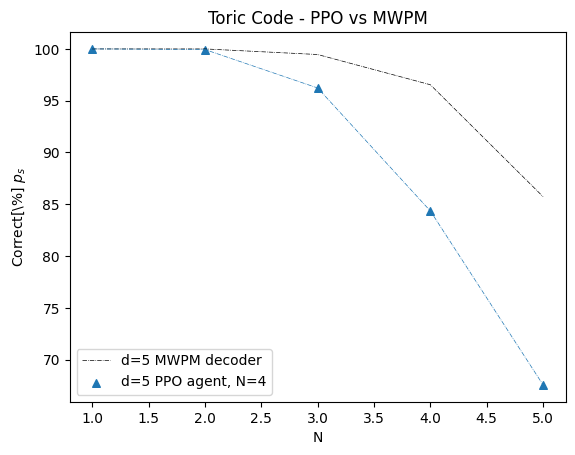

In [26]:
#run the script


success_rates_all=[]
success_rates_all_MWPM=[]


if fixed:
    curriculums=N_curriculums
else:
    curriculums=error_rates_curriculum


for curriculum_val in curriculums:

    if (train==True) and (curriculum == False) and(curriculums.index(curriculum_val)>0):
        train=False
        curriculum=True


    save_model_path =''
    for key, value in initialisation_settings.items():
        save_model_path+=f"{key}={value}"


    load_model_path =''
    for key, value in loaded_model_settings.items():
        load_model_path+=f"{key}={value}"




    #initialise PPO Agent
    AgentPPO = PPO_agent(initialisation_settings, log)

    if train:
        AgentPPO.train_model(save_model_path=save_model_path)
    else:
        print(f"{loaded_model_settings['N']=}")
        AgentPPO.load_model(load_model_path=load_model_path)
        

    if curriculum:
        if fixed:
        
            print(f"{curriculum_val=}")
            initialisation_settings['N']=curriculum_val
        else:
            print(f"{curriculum_val=}")
            initialisation_settings['error_rate']=curriculum_val



        save_model_path =''
        for key, value in initialisation_settings.items():
            save_model_path+=f"{key}={value}"

        AgentPPO.change_environment_settings(initialisation_settings)

        AgentPPO.train_model(save_model_path=save_model_path)
        
        if fixed:
            loaded_model_settings['N']=curriculum_val
        else:
            loaded_model_settings['error_rate']=curriculum_val



    if evaluate:

        if evaluate_fixed:
            success_rates, success_rates_MWPM,observations, results, actions = AgentPPO.evaluate_fixed_errors(evaluation_settings, N_evaluates, render, number_evaluations, max_moves, check_fails, save_files)
        else:
            success_rates, success_rates_MWPM,observations, results, actions = AgentPPO.evaluate_error_rates(evaluation_settings, error_rates_eval, render, number_evaluations, max_moves, check_fails, save_files, fixed)


        success_rates_all.append(success_rates)
        success_rates_all_MWPM.append(success_rates_MWPM)



evaluation_path =''
for key, value in evaluation_settings.items():
    evaluation_path+=f"{key}={value}"



success_rates_all=np.array(success_rates_all)
success_rates_all_MWPM=np.array(success_rates_all_MWPM)



if fixed:
    path_plot = f"PPO_vs_MWPM_{evaluation_path}_{loaded_model_settings['N']}.pdf"
else:
    path_plot = f"PPO_vs_MWPM_{evaluation_path}_{loaded_model_settings['error_rate']}.pdf"


plot_benchmark_MWPM(success_rates_all, success_rates_all_MWPM, error_rates_eval, board_size,path_plot,loaded_model_settings['N'], loaded_model_settings['error_rate'],evaluate_fixed)